<a href="https://colab.research.google.com/github/WilliamShengYangHuang/RC18_Machine_Learning/blob/main/Conditional_Reasoning_Using_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import History

In [4]:
# Read data from CSV file
data = pd.read_csv('/content/california_housing_train.csv')
data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15,5612,1283,1015,472,1.4936,66900
1,-114.47,34.40,19,7650,1901,1129,463,1.8200,80100
2,-114.56,33.69,17,720,174,333,117,1.6509,85700
3,-114.57,33.64,14,1501,337,515,226,3.1917,73400
4,-114.57,33.57,20,1454,326,624,262,1.9250,65500
...,...,...,...,...,...,...,...,...,...
16995,-124.26,40.58,52,2217,394,907,369,2.3571,111400
16996,-124.27,40.69,36,2349,528,1194,465,2.5179,79000
16997,-124.30,41.84,17,2677,531,1244,456,3.0313,103600
16998,-124.30,41.80,19,2672,552,1298,478,1.9797,85800


Epoch 1/50
170/170 [==============================] - 6s 4ms/step - loss: 4.1610
Epoch 2/50
170/170 [==============================] - 1s 4ms/step - loss: 3.6902
Epoch 3/50
170/170 [==============================] - 1s 4ms/step - loss: 3.6888
Epoch 4/50
170/170 [==============================] - 1s 4ms/step - loss: 3.6879
Epoch 5/50
170/170 [==============================] - 1s 4ms/step - loss: 3.6872
Epoch 6/50
170/170 [==============================] - 1s 4ms/step - loss: 3.6872
Epoch 7/50
170/170 [==============================] - 1s 4ms/step - loss: 3.6868
Epoch 8/50
170/170 [==============================] - 1s 4ms/step - loss: 3.6863
Epoch 9/50
170/170 [==============================] - 1s 4ms/step - loss: 3.6858
Epoch 10/50
170/170 [==============================] - 1s 4ms/step - loss: 3.6853
Epoch 11/50
170/170 [==============================] - 1s 6ms/step - loss: 3.6855
Epoch 12/50
170/170 [==============================] - 1s 6ms/step - loss: 3.6846
Epoch 13/50
170/170 [====

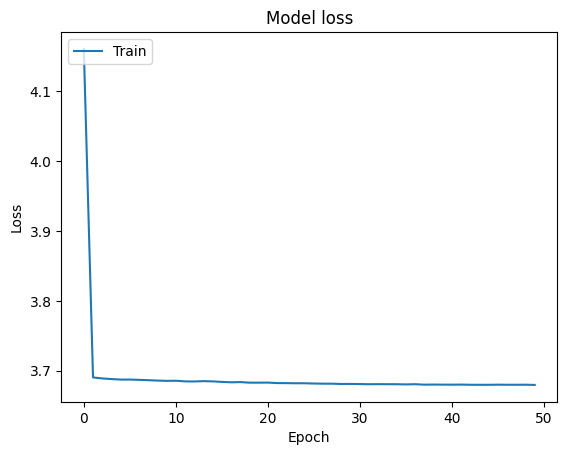

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 190ms/step
Predicted values:
Longitude: -118.87
Latitude: 33.11
Housing Median Age: 27.20
Total Rooms: -1390.40
Total Bedrooms: -242.21
Population: -881.44
Households: 245.55
Median Income: 10000.00
Median House Value: 163687.00


In [2]:
# Preprocess data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Split input and output data
X = data_scaled[:, 7:8]  # median_income
Y = data_scaled[:, [0,1,2,3,4,5,6,8]]  # other attributes

# Define model parameters
original_dim = Y.shape[1]
latent_dim = 2
intermediate_dim = 256
epsilon_std = 1.0

# Define encoder
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# Define sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# Get latent variable z through sampling function
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Define decoder
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim)  # remove the sigmoid activation
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# Build model
vae = Model(x, x_decoded_mean)

# Define loss function and compile model
xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')

# Train model and save history
history = History()
EPOCHS = 50 #@param{type:'slider', min:0, max:10000, step:1}
vae.fit(Y, shuffle=True, epochs=50, batch_size=100, callbacks=[history])

# Plot loss function
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Test income of 10000
income_test = 10000 #@param{type:'slider', min:0, max:300000, step:1}

# Normalise using previous scaler
income_test_scaled = scaler.transform([[0, 0, 0, 0, 0, 0, 0, income_test, 0]])

# Generate new data using model
new_Y_test = vae.predict(income_test_scaled[:, :original_dim])

# Add income data
new_Y_test_with_income = np.insert(new_Y_test, 7, income_test_scaled[:, 7], axis=1)

# Convert data back to original range
new_Y_test_unscaled = scaler.inverse_transform(new_Y_test_with_income)

# Print predicted values
print("Predicted values:")
print("Longitude: {:.2f}".format(new_Y_test_unscaled[0][0]))
print("Latitude: {:.2f}".format(new_Y_test_unscaled[0][1]))
print("Housing Median Age: {:.2f}".format(new_Y_test_unscaled[0][2]))
print("Total Rooms: {:.2f}".format(new_Y_test_unscaled[0][3]))
print("Total Bedrooms: {:.2f}".format(new_Y_test_unscaled[0][4]))
print("Population: {:.2f}".format(new_Y_test_unscaled[0][5]))
print("Households: {:.2f}".format(new_Y_test_unscaled[0][6]))
print("Median Income: {:.2f}".format(new_Y_test_unscaled[0][7]))
print("Median House Value: {:.2f}".format(new_Y_test_unscaled[0][8]))


170/170 [==============================] - 0s 1ms/step


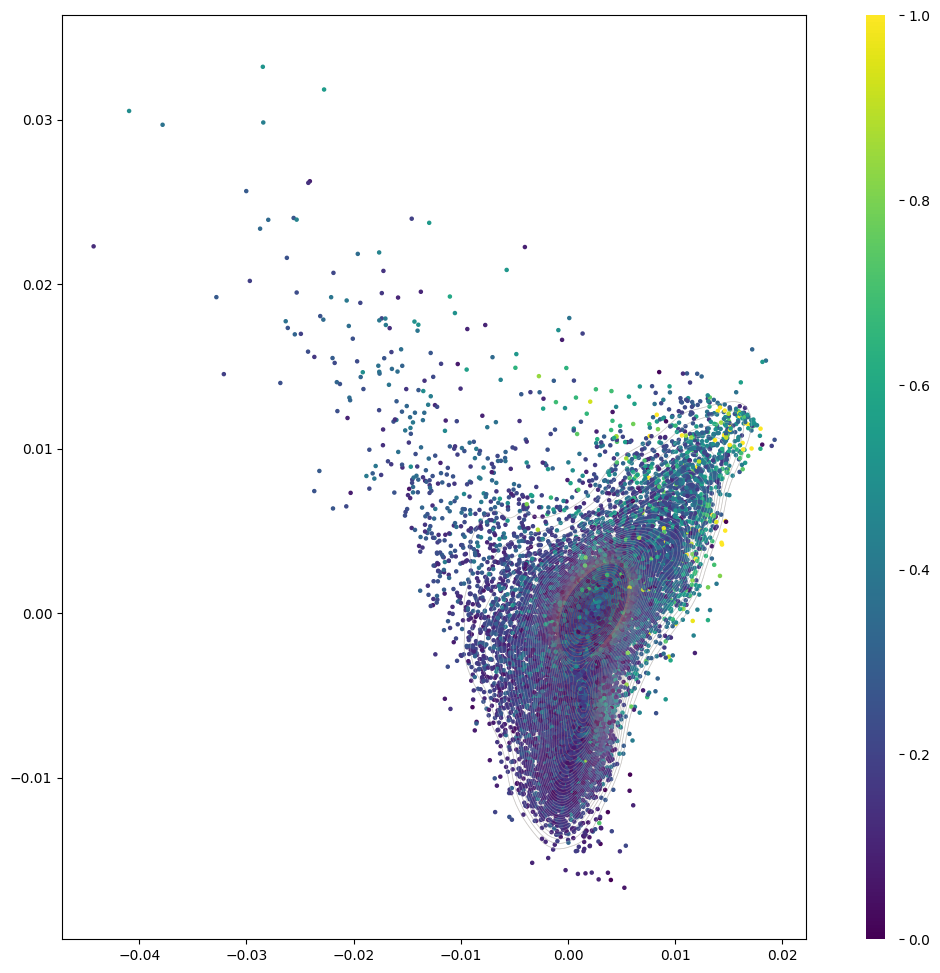

In [3]:


# Create a model to map the input to its latent space mean
encoder = Model(x, z_mean)

# Display the 2D latent space of the digit classes
x_test_encoded = encoder.predict(Y, batch_size=100)
plt.figure(figsize=(12, 12))

# First, plot the kernel density estimate
sns.kdeplot(x=x_test_encoded[:, 0], y=x_test_encoded[:, 1], cmap="Greys_r", fill=False, levels=50, thresh=0.05, linewidths=0.5, alpha=0.3, zorder=0)
sns.kdeplot(x=x_test_encoded[:, 0], y=x_test_encoded[:, 1], cmap="Oranges", fill=False, levels=50, thresh=0.05, linewidths=0.5, alpha=0.3, zorder=10000)

# Then, plot the scatter plot
scatter = plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=X.flatten(), s=5)

# Adjust the width of the colour bar
cbar = plt.colorbar()
cbar.ax.set_aspect(50)  # Set the width of the colour bar
cbar.outline.set_visible(False)

plt.show()
